# Machine Learning 
This file builds the training dataset from the multiple csv files of the kaggle challenge. It applies four different prediction models and evaluates the importance of the 156 features built and the learning curve of the models.

In [1]:
import pandas as pd
import numpy as np
import time
import machine_learning_helper as machine_learning_helper
import metrics_helper as metrics_helper
import sklearn.neighbors, sklearn.linear_model, sklearn.ensemble, sklearn.naive_bayes
from sklearn.model_selection import KFold, train_test_split, ShuffleSplit
from sklearn import model_selection
from sklearn import ensemble
from xgboost.sklearn import XGBClassifier
import scipy as sp
import xgboost as xgb
import matplotlib.pyplot as plt 
% matplotlib inline
from sklearn.model_selection import learning_curve
from sklearn import linear_model, datasets
import os

## Read .csv files

In [2]:
dataFolder = 'cleaned_data'
resultFolder = 'results'
filenameAdress_train_user = 'cleaned_train_user.csv'
filenameAdress_test_user = 'cleaned_test_user.csv'
filenameAdress_time_mean_user_id = 'time_mean_user_id.csv'
filenameAdress_time_total_user_id = 'time_total_user_id.csv'
filenameAdress_total_action_user_id = 'total_action_user_id.csv'

df_train_users = pd.read_csv(os.path.join(dataFolder, filenameAdress_train_user))
df_test_users = pd.read_csv(os.path.join(dataFolder, filenameAdress_test_user))
df_time_mean_user_id = pd.read_csv(os.path.join(dataFolder, filenameAdress_time_mean_user_id))
df_time_total_user_id = pd.read_csv(os.path.join(dataFolder, filenameAdress_time_total_user_id))
df_total_action_user_id = pd.read_csv(os.path.join(dataFolder, filenameAdress_total_action_user_id))

## Construct sessions data frame
This dataframe contains the features that were extracted from the file sessions. For more information about these features, see notebook Main preprocessing. 

In [3]:
df_total_action_user_id.columns = ['id','action']
df_sessions = pd.merge(df_time_mean_user_id, df_time_total_user_id, on='id', how='outer')
df_sessions = pd.merge(df_sessions, df_total_action_user_id, on='id', how='outer')
df_sessions.columns = ['id','time_mean_user','time_total_user','action']

## 1. From data frame to matrix : Construct y_train

The destination countries, now as string, are encoded in int format. Each country will be assigned to a int.

In [4]:
y_labels, label_enc = machine_learning_helper.buildTargetMat(df_train_users)

## 2. From data frame to matrix : Construct X_train & X_test

### Feature engineering.
Added features : 
- time_mean_user
- time_total_user
- total_action_user
- Date created account
- Date first active


In [5]:
X_train, X_test = machine_learning_helper.buildFeatsMat(df_train_users, df_test_users, df_sessions)

In [6]:
#X_train = X_train[200000:201000]
#y_labels = y_labels[200000:201000]

For Memory purpose, the train matrix is formatted in sparse

In [7]:
X_train_sparse = sp.sparse.csr_matrix(X_train.values)

## 3. Cross validation setup
5 folds cross validation, shuffled.


In [8]:
cv = model_selection.KFold(n_splits=5, random_state=None, shuffle=True)

# 4. Machine Learning 
Several models are tried, and their parameter optimized through Cross validation. The code is optimized to run on 12 processors at the same time. The metric used is the NDCG. Because of the computation complexity, the for loops for the cross validations were not nested.


Models that were tried:
- **Random Forest**
- **eXtreme Gradient Boosting XCGB**
- **2 layers stack model**:
    - Logistic regression
    - eXtreme Gradient Boosting XCGB
- **Voting classifer**
    - Random Forest
    - eXtreme Gradient Boosting XCGB
    - 2 layers stack model
    


# Model 1 : RandomForest

In [9]:
number_trees = [125, 300, 500, 600 ]
max_depth = [5, 8, 12, 16, 20]

rf_score_trees = []
rf_score_depth = []
rf_param_trees = []
rf_param_depth = []

#Loop for hyperparameter number_trees
for number_trees_idx, number_trees_value in enumerate(number_trees):
    
    print('number_trees_idx: ',number_trees_idx+1,'/',len(number_trees),', value: ', number_trees_value)

    # Random forest
    rand_forest_model = ensemble.RandomForestClassifier(n_estimators=number_trees_value, max_depth=14)

    #Scores
    scores = model_selection.cross_val_score(rand_forest_model, X_train_sparse, y_labels, cv=cv, verbose = 10, n_jobs = 12, scoring=metrics_helper.ndcg_scorer)
    rf_score_trees.append(scores.mean())
    rf_param_trees.append(number_trees_value)
    print('Mean NDCG for this number_trees = ', scores.mean())

# best number of trees from above
print() 
print('best NDCG:')
print(np.max(rf_score_trees))
print('best parameter num_trees:')
idx_best = np.argmax(rf_score_trees)
best_num_trees_RF = rf_param_trees[idx_best]
print(best_num_trees_RF)

number_trees_idx:  1 / 4 , value:  125
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.823250, total= 3.0min
[CV] ................................. , score=0.822400, total= 3.1min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  3.1min remaining:  4.6min


[CV] ................................. , score=0.822188, total= 3.2min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  3.3min remaining:  2.2min


[CV] ................................. , score=0.823148, total= 3.3min
[CV] ................................. , score=0.822983, total= 3.3min
Mean NDCG for this number_trees =  0.8227937445
number_trees_idx:  2 / 4 , value:  300


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  3.3min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.824263, total= 6.5min
[CV] ................................. , score=0.823940, total= 6.6min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  6.6min remaining: 10.0min


[CV] ................................. , score=0.823161, total= 6.8min
[CV] ................................. , score=0.823372, total= 6.8min
[CV] ................................. , score=0.823016, total= 6.8min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  6.8min remaining:  4.5min
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  6.8min finished


Mean NDCG for this number_trees =  0.823550260161
number_trees_idx:  3 / 4 , value:  500
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.824988, total=10.6min
[CV] ................................. , score=0.823906, total=10.7min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed: 10.8min remaining: 16.2min


[CV] ................................. , score=0.821613, total=11.1min
[CV] ................................. , score=0.821574, total=11.1min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed: 11.1min remaining:  7.4min


[CV] ................................. , score=0.824170, total=11.3min


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed: 11.3min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed: 11.3min finished


Mean NDCG for this number_trees =  0.823250365603
number_trees_idx:  4 / 4 , value:  600
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.824449, total=12.9min
[CV] ................................. , score=0.821773, total=13.0min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed: 13.0min remaining: 19.6min


[CV] ................................. , score=0.821790, total=13.4min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed: 13.5min remaining:  9.0min


[CV] ................................. , score=0.822415, total=13.6min
[CV] ................................. , score=0.826529, total=13.6min


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed: 13.6min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed: 13.6min finished


Mean NDCG for this number_trees =  0.823391338742

best NDCG:
0.823550260161
best parameter num_trees:
300


In [10]:
#Loop for hyperparameter max_depth
for max_depth_idx, max_depth_value in enumerate(max_depth):
    
    print('max_depth_idx: ',max_depth_idx+1,'/',len(max_depth),', value: ', max_depth_value)

    # Random forest
    rand_forest_model = ensemble.RandomForestClassifier(n_estimators=best_num_trees_RF, max_depth=max_depth_value)

    #Scores
    scores = model_selection.cross_val_score(rand_forest_model, X_train_sparse, y_labels, cv=cv, verbose = 10, n_jobs = 12, scoring=metrics_helper.ndcg_scorer)
    rf_score_depth.append(scores.mean())
    rf_param_depth.append(max_depth_value)
    print('Mean NDCG for this max:_depth = ', scores.mean())
    
# best max_depth from above
print() 
print('best NDCG:')
print(np.max(rf_score_depth))
print('best parameter max_depth:')
idx_best = np.argmax(rf_score_depth)
best_max_depth_RF = rf_param_depth[idx_best]
print(best_max_depth_RF)

max_depth_idx:  1 / 5 , value:  5
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.806607, total= 1.7min
[CV] ................................. , score=0.807307, total= 1.7min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.7min


[CV] ................................. , score=0.807864, total= 1.8min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  1.9min remaining:  1.3min


[CV] ................................. , score=0.807311, total= 1.9min
[CV] ................................. , score=0.807696, total= 1.9min
Mean NDCG for this max:_depth =  0.807356993015
max_depth_idx:  2 / 5 , value:  8


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  2.0min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.810027, total= 1.6min
[CV] ................................. , score=0.813214, total= 1.6min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.5min


[CV] ................................. , score=0.814571, total= 1.7min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  1.7min remaining:  1.2min


[CV] ................................. , score=0.811501, total= 1.7min
[CV] ................................. , score=0.812019, total= 1.8min
Mean NDCG for this max:_depth =  0.812266600314
max_depth_idx:  3 / 5 , value:  12


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  1.8min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.819976, total= 4.0min
[CV] ................................. , score=0.819409, total= 4.0min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  4.0min remaining:  6.0min


[CV] ................................. , score=0.820405, total= 4.3min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  4.3min remaining:  2.8min


[CV] ................................. , score=0.819701, total= 4.3min
[CV] ................................. , score=0.822138, total= 4.3min
Mean NDCG for this max:_depth =  0.820325731789
max_depth_idx:  4 / 5 , value:  16


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.3min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.823497, total=10.9min
[CV] ................................. , score=0.824418, total=11.0min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed: 11.1min remaining: 16.6min


[CV] ................................. , score=0.823840, total=11.4min
[CV] ................................. , score=0.825570, total=11.4min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed: 11.4min remaining:  7.6min


[CV] ................................. , score=0.823405, total=12.0min


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed: 12.0min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed: 12.0min finished


Mean NDCG for this max:_depth =  0.824146068328
max_depth_idx:  5 / 5 , value:  20
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.824016, total=24.5min
[CV] ................................. , score=0.821911, total=24.7min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed: 24.8min remaining: 37.2min


[CV] ................................. , score=0.824852, total=25.0min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed: 25.2min remaining: 16.8min


[CV] ................................. , score=0.821798, total=25.9min
[CV] ................................. , score=0.824487, total=26.0min


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed: 26.1min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed: 26.1min finished


Mean NDCG for this max:_depth =  0.823412643535

best NDCG:
0.824146068328
best parameter max_depth:
16


** Random forest 600 trees, 16 depth **
 - **NDCG = 0.821472784776**
 - **Kaggle Private Leader Board NDCG = 0.86686**

## Predict Countries and convert to CSV for submision for RF model

In [11]:
best_num_trees_RF = 600
best_max_depth_RF = 16

rand_forest_model = ensemble.RandomForestClassifier(n_estimators=best_num_trees_RF, max_depth=best_max_depth_RF)
rand_forest_model.fit(X_train_sparse,y_labels)
y_pred1 = rand_forest_model.predict_proba(X_test)  
id_test = df_test_users['id']
cts1,idsubmission1 = machine_learning_helper.get5likelycountries(y_pred1, id_test)

ctsSubmission1 = label_enc.inverse_transform(cts1)

# Save to csv
df_submission1 = pd.DataFrame(np.column_stack((idsubmission1, ctsSubmission1)), columns=['id', 'country'])
df_submission1.to_csv(os.path.join(resultFolder, 'submission_country_dest_RF.csv'),index=False)

# Model 2 : eXtreme Gradient Boosting XCGB

5 folds cross validation, using ndcg as scoring metric.

Grid Search to find best parameter.

In [12]:
learning_rates = [0.001, 0.01, 0.05,0.1, 0.2]
max_depth = [3, 5, 7, 9, 12]
n_estimators = [20,30,50,75,100]
gamma = [0,0.3, 0.5, 0.7, 1]

best_gamma_XCG, best_num_estimators_XCG,best_num_depth_XCG, best_learning_rate_XCG = machine_learning_helper.CrossVal_XGB(X_train_sparse, y_labels, cv,max_depth,n_estimators,learning_rates,gamma)


max_depth_idx:  1 / 5 , value:  3
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.826627, total= 4.2min
[CV] ................................. , score=0.826178, total= 4.3min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  4.3min remaining:  6.4min


[CV] ................................. , score=0.824289, total= 4.3min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  4.3min remaining:  2.9min


[CV] ................................. , score=0.825185, total= 4.4min
[CV] ................................. , score=0.826337, total= 4.4min
Mean NDCG for this max_depth =  0.825723017469
max_depth_idx:  2 / 5 , value:  5


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.4min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.826289, total= 5.6min
[CV] ................................. , score=0.825109, total= 5.6min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  5.6min remaining:  8.4min


[CV] ................................. , score=0.824918, total= 5.8min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  5.8min remaining:  3.9min


[CV] ................................. , score=0.827647, total= 5.9min
[CV] ................................. , score=0.827370, total= 5.9min
Mean NDCG for this max_depth =  0.826266458724
max_depth_idx:  3 / 5 , value:  7


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  5.9min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.825215, total= 7.3min
[CV] ................................. , score=0.827191, total= 7.4min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  7.4min remaining: 11.1min


[CV] ................................. , score=0.824492, total= 7.5min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  7.5min remaining:  5.0min


[CV] ................................. , score=0.826925, total= 7.6min
[CV] ................................. , score=0.826692, total= 7.6min
Mean NDCG for this max_depth =  0.826103042473
max_depth_idx:  4 / 5 , value:  9


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  7.6min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  7.6min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.826725, total= 8.6min
[CV] ................................. , score=0.825478, total= 8.7min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  8.7min remaining: 13.0min


[CV] ................................. , score=0.826051, total= 8.9min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  8.9min remaining:  5.9min


[CV] ................................. , score=0.825827, total= 8.9min
[CV] ................................. , score=0.823832, total= 8.9min
Mean NDCG for this max_depth =  0.825582703368
max_depth_idx:  5 / 5 , value:  12


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  8.9min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  8.9min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.824214, total=11.0min
[CV] ................................. , score=0.824091, total=11.0min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed: 11.1min remaining: 16.6min


[CV] ................................. , score=0.825889, total=11.3min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed: 11.3min remaining:  7.5min


[CV] ................................. , score=0.822880, total=11.3min
[CV] ................................. , score=0.825442, total=11.4min
Mean NDCG for this max_depth =  0.824503114884

best NDCG:
0.826266458724
best parameter max_depth:
5
n_estimators_idx:  1 / 5 , value:  20


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed: 11.4min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed: 11.4min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.823501, total= 1.4min
[CV] ................................. , score=0.821253, total= 1.5min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.3min


[CV] ................................. , score=0.823708, total= 1.6min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  1.6min remaining:  1.1min


[CV] ................................. , score=0.825200, total= 1.7min
[CV] ................................. , score=0.824161, total= 1.7min
Mean NDCG for this n_estimators =  0.823564675404
n_estimators_idx:  2 / 5 , value:  30


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  1.7min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.825589, total= 2.2min
[CV] ................................. , score=0.824641, total= 2.2min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.3min


[CV] ................................. , score=0.826153, total= 2.3min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  2.3min remaining:  1.5min


[CV] ................................. , score=0.824603, total= 2.3min
[CV] ................................. , score=0.825109, total= 2.3min
Mean NDCG for this n_estimators =  0.825218841071
n_estimators_idx:  3 / 5 , value:  50


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  2.3min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.825004, total= 3.1min
[CV] ................................. , score=0.826439, total= 3.1min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  3.1min remaining:  4.7min


[CV] ................................. , score=0.826203, total= 3.2min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  3.2min remaining:  2.1min


[CV] ................................. , score=0.826845, total= 3.3min
[CV] ................................. , score=0.825019, total= 3.3min
Mean NDCG for this n_estimators =  0.825901896921
n_estimators_idx:  4 / 5 , value:  75


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  3.3min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.825322, total= 4.4min
[CV] ................................. , score=0.827764, total= 4.6min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  4.6min remaining:  6.9min


[CV] ................................. , score=0.825150, total= 4.6min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  4.6min remaining:  3.1min


[CV] ................................. , score=0.825852, total= 4.7min
[CV] ................................. , score=0.827528, total= 4.7min
Mean NDCG for this n_estimators =  0.826323162738
n_estimators_idx:  5 / 5 , value:  100


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.7min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.7min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.824211, total= 5.6min
[CV] ................................. , score=0.824591, total= 5.6min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  5.6min remaining:  8.4min


[CV] ................................. , score=0.826036, total= 5.8min
[CV] ................................. , score=0.828457, total= 5.8min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  5.8min remaining:  3.9min


[CV] ................................. , score=0.827771, total= 5.8min
Mean NDCG for this n_estimators =  0.826213335215

best NDCG:
0.826323162738
best parameter num_estimators:
75
gamma_idx:  1 / 5 , value:  0


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  5.9min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.825259, total= 4.3min
[CV] ................................. , score=0.826295, total= 4.4min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  4.4min remaining:  6.7min


[CV] ................................. , score=0.826170, total= 4.5min
[CV] ................................. , score=0.826949, total= 4.5min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  4.5min remaining:  3.0min


[CV] ................................. , score=0.825979, total= 4.6min


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.6min finished


Mean NDCG for this gamma =  0.826130333123
gamma_idx:  2 / 5 , value:  0.3
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.826347, total= 4.3min
[CV] ................................. , score=0.825999, total= 4.4min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  4.4min remaining:  6.6min


[CV] ................................. , score=0.825412, total= 4.5min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  4.5min remaining:  3.0min


[CV] ................................. , score=0.825272, total= 4.5min
[CV] ................................. , score=0.827816, total= 4.6min
Mean NDCG for this gamma =  0.826169223066
gamma_idx:  3 / 5 , value:  0.5


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.6min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.828282, total= 4.3min
[CV] ................................. , score=0.825766, total= 4.4min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  4.4min remaining:  6.7min


[CV] ................................. , score=0.825982, total= 4.5min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  4.5min remaining:  3.0min


[CV] ................................. , score=0.825071, total= 4.6min
[CV] ................................. , score=0.826093, total= 4.6min
Mean NDCG for this gamma =  0.826238839612
gamma_idx:  4 / 5 , value:  0.7


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.6min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.825765, total= 4.3min
[CV] ................................. , score=0.827327, total= 4.3min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  4.3min remaining:  6.5min


[CV] ................................. , score=0.826289, total= 4.5min
[CV] ................................. , score=0.824505, total= 4.5min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  4.5min remaining:  3.0min


[CV] ................................. , score=0.827393, total= 4.6min
Mean NDCG for this gamma =  0.826255824131
gamma_idx:  5 / 5 , value:  1


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.6min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.826876, total= 4.3min
[CV] ................................. , score=0.825541, total= 4.4min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  4.4min remaining:  6.5min


[CV] ................................. , score=0.825725, total= 4.6min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  4.6min remaining:  3.0min


[CV] ................................. , score=0.826990, total= 4.6min
[CV] ................................. , score=0.825617, total= 4.6min
Mean NDCG for this gamma =  0.826149660378

best NDCG:
0.826255824131
best parameter gamma:
0.7
learning_rates_idx:  1 / 5 , value:  0.001


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.6min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.817360, total= 4.0min
[CV] ................................. , score=0.820376, total= 4.1min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  4.1min remaining:  6.1min


[CV] ................................. , score=0.817871, total= 4.2min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  4.2min remaining:  2.8min


[CV] ................................. , score=0.818509, total= 4.3min
[CV] ................................. , score=0.819073, total= 4.3min


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.3min finished


Mean NDCG for this learning rate =  0.818637797565
learning_rates_idx:  2 / 5 , value:  0.01
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.821431, total= 4.1min
[CV] ................................. , score=0.820942, total= 4.1min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  4.1min remaining:  6.2min


[CV] ................................. , score=0.821500, total= 4.4min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  4.4min remaining:  2.9min


[CV] ................................. , score=0.819963, total= 4.4min
[CV] ................................. , score=0.823195, total= 4.4min
Mean NDCG for this learning rate =  0.82140622416
learning_rates_idx:  3 / 5 , value:  0.05


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.4min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.825976, total= 4.4min
[CV] ................................. , score=0.825607, total= 4.5min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  4.5min remaining:  6.7min


[CV] ................................. , score=0.826213, total= 4.6min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  4.6min remaining:  3.1min


[CV] ................................. , score=0.825953, total= 4.7min
[CV] ................................. , score=0.824136, total= 4.7min


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.7min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.7min finished


Mean NDCG for this learning rate =  0.825576932326
learning_rates_idx:  4 / 5 , value:  0.1
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.826047, total= 4.3min
[CV] ................................. , score=0.826563, total= 4.5min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  4.5min remaining:  6.7min


[CV] ................................. , score=0.825056, total= 4.5min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  4.5min remaining:  3.0min


[CV] ................................. , score=0.827756, total= 4.6min
[CV] ................................. , score=0.826548, total= 4.6min
Mean NDCG for this learning rate =  0.826394051995
learning_rates_idx:  5 / 5 , value:  0.2


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.6min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.824944, total= 4.4min
[CV] ................................. , score=0.827113, total= 4.5min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:  4.5min remaining:  6.7min


[CV] ................................. , score=0.826993, total= 4.6min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:  4.6min remaining:  3.1min


[CV] ................................. , score=0.825877, total= 4.7min
[CV] ................................. , score=0.825289, total= 4.8min
Mean NDCG for this learning rate =  0.826043084423

best NDCG:
0.826394051995
best parameter learning rates:
0.1


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.8min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:  4.8min finished


** XGboost - learning_rate = 0.1, gamma =1, depth = 7, estimators = 75 **
 - **NDCG = 0.826134**
 - **Kaggle Private Leader Board NDCG = 0.86967 (rank 756)**

** XGboost - learning_rate = 0.1, gamma =0.7, depth = 5, estimators = 75 **
 - **NDCG = 0.826394**
 - **Kaggle Private Leader Board NDCG = 0.86987 (rank 698)**


## Predict Countries and convert to CSV for submision of xgb model

In [204]:
best_learning_rate_XCG = 0.1
best_num_depth_XCG = 5
best_gamma_XCG = 0.7
best_num_estimators_XCG = 75

XGB_model = XGBClassifier(max_depth=best_num_depth_XCG, learning_rate=best_learning_rate_XCG, n_estimators=best_num_estimators_XCG,objective='multi:softprob',
                      subsample=0.5, colsample_bytree=0.5, gamma = best_gamma_XCG)
XGB_model.fit(X_train,y_labels, eval_metric=metrics_helper.ndcg_scorer)
y_pred2 = XGB_model.predict_proba(X_test)  
id_test = df_test_users['id']
cts2,idsubmission2 = machine_learning_helper.get5likelycountries(y_pred2, id_test)

ctsSubmission2 = label_enc.inverse_transform(cts2)


df_submission2 = pd.DataFrame(np.column_stack((idsubmission2, ctsSubmission2)), columns=['id', 'country'])
df_submission2.to_csv(os.path.join(resultFolder, 'submission_country_dest_XGB.csv'),index=False)

## Model 3 : Stacking 

As seen previously, the classes in this dataset are unbalanced. Indeed, half of the users didn't book. We are going to try to make good use of that information.

This model is composed of 2 layers :
- In a first layer, a logistic regression determines if a user is going to book or not. This binary classification model is trained on the training set. The prediction on the test set by this model is added to a second layer, as a meta feature.

A small mistake : For the training of the 1st layer, the features of the date_account_created and timestamp_first_active were not used.

- The second layer is an XGBoost algorithm. It is trained on the new training set, which is made on the original one connected with the output of the first layer under the column 'meta_layer_1'.

<img src="https://s23.postimg.org/8g018p4a3/1111.png">

### Layer 1 : Logistic regression

This logistic regressionw will determine if a user booked or not. It is a binary classification problem.

In [9]:
# Build 1st layer training matrix, text matrix, target vector
y_labels_binary, X_train_layer1, X_test_layer1 = machine_learning_helper.buildFeatsMatBinary(df_train_users, df_test_users, df_sessions)
#y_labels_binary = y_labels_binary[0:1000]
#X_train_layer1 = X_train_layer1[0:1000]
y_labels_binary = y_labels_binary.astype(np.int8)


In [10]:

# Build 1st layer model
# Cross validation with parameter C

C = [0.1, 1.0, 10, 100, 1000]
logistic_score_C = []
logistic_param_C = []

#Loop for hyperparameter 
for C_idx, C_value in enumerate(C):
    
    print('C_idx: ',C_idx+1,'/',len(C),', value: ', C_value)

    # Logistic
    model = linear_model.LogisticRegression(C = C_value)

    #Scores
    scores = model_selection.cross_val_score(model, X_train_layer1, y_labels_binary, cv=cv, verbose = 10, scoring='f1', n_jobs = 12)
    logistic_score_C.append(scores.mean())
    logistic_param_C.append(C_value)
    print('Mean f1 for this C = ', scores.mean())

# best C from above
print() 
print('best f1:')
print(np.max(logistic_score_C))
print('best parameter C:')
idx_best = np.argmax(logistic_score_C)
best_C_logistic = logistic_param_C[idx_best]
print(best_C_logistic)

# Build model with best parameter from cross validation
logreg_layer1 = linear_model.LogisticRegression(C = best_C_logistic)
logreg_layer1.fit(X_train_layer1, y_labels_binary)
score_training = logreg_layer1.predict(X_train_layer1)

# 1st layer model prediction
prediction_layer_1 = logreg_layer1.predict(X_test_layer1)

C_idx:  1 / 5 , value:  0.1
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.600124, total=   2.4s
[CV] ................................. , score=0.609375, total=   2.3s


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.1s


[CV] ................................. , score=0.607596, total=   3.0s
[CV] ................................. , score=0.581368, total=   3.1s


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:    3.3s remaining:    2.2s


[CV] ................................. , score=0.475695, total=   4.2s


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:    4.3s finished


Mean f1 for this C =  0.574831331763
C_idx:  2 / 5 , value:  1.0
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.609807, total=   2.2s
[CV] ................................. , score=0.612005, total=   2.4s
[CV] ................................. , score=0.603054, total=   2.2s


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:    2.7s remaining:    1.8s


[CV] ................................. , score=0.611950, total=   2.5s
[CV] ................................. , score=0.442504, total=   3.6s
Mean f1 for this C =  0.57586396186
C_idx:  3 / 5 , value:  10


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:    3.8s finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.610190, total=   2.3s
[CV] ................................. , score=0.613748, total=   2.5s
[CV] ................................. , score=0.603591, total=   2.8s


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.2s
[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:    3.0s remaining:    2.0s


[CV] ................................. , score=0.607194, total=   3.0s
[CV] ................................. , score=0.566278, total=   3.3s
Mean f1 for this C =  0.600200061885
C_idx:  4 / 5 , value:  100


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:    3.7s finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.608356, total=   2.3s
[CV] ................................. , score=0.607252, total=   2.2s
[CV] ................................. , score=0.608100, total=   2.3s


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:    2.7s remaining:    1.8s


[CV] ................................. , score=0.561100, total=   4.1s
[CV] ................................. , score=0.489609, total=   4.1s
Mean f1 for this C =  0.574883478532
C_idx:  5 / 5 , value:  1000


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:    4.3s finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.612515, total=   2.4s
[CV] ................................. , score=0.603756, total=   2.6s


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.2s


[CV] ................................. , score=0.580924, total=   3.3s


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed:    3.7s remaining:    2.5s


[CV] ................................. , score=0.597618, total=   3.9s
[CV] ................................. , score=0.533735, total=   4.1s


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed:    4.2s finished


Mean f1 for this C =  0.585709383689

best f1:
0.600200061885
best parameter C:
10


Training accuracy:

In [13]:
from sklearn import metrics
metrics.accuracy_score(y_labels_binary,score_training)

0.60775072499074734

### Layer 2 : XGBoost

Using the previous result as a meta_feature, this model will determine the 5 most likely countries in which a user will travel.

In [ ]:

# Build 2nd layer training matrix, text matrix, target vector

#df_train_users.reset_index(inplace=True,drop=True)
#y_labels, label_enc = machine_learning_helper.buildTargetMat(df_train_users)
#y_labels = y_labels[0:1000]
#X_train_layer1 = X_train_layer1[0:1000]
                                
X_train_layer2 = X_train_layer1
X_train_layer2['meta_layer_1'] = pd.Series(y_labels_binary).astype(np.int8)
X_test_layer2 = X_test_layer1
X_test_layer2['meta_layer_1'] = pd.Series(prediction_layer_1).astype(np.int8)

learning_rates = [0.001, 0.01, 0.05,0.1, 0.2]
max_depth = [3, 5, 7, 9, 12]
n_estimators = [20,30,50,75,100]
gamma = [0,0.3, 0.5, 0.7, 1]
cv2 = model_selection.KFold(n_splits=5, random_state=None, shuffle=True)
best_gamma_XCG, best_num_estimators_XCG,best_num_depth_XCG, best_learning_rate_XCG = machine_learning_helper.CrossVal_XGB(X_train_layer2, y_labels, cv2,max_depth,n_estimators,learning_rates,gamma)

** 2 layers stack model - learning_rate = 0.1, gamma =0.7, depth = 5, estimators = 75**
 - **Kaggle Private Leader Board NDCG = 0.82610**

## Predict Countries and convert to CSV for submision of 2 Layer Stack model

In [19]:
best_learning_rate_XCG = 0.1
best_num_depth_XCG = 5
best_gamma_XCG = 0.7
best_num_estimators_XCG = 50

XGB_model = XGBClassifier(max_depth=best_num_depth_XCG, learning_rate=best_learning_rate_XCG, n_estimators=best_num_estimators_XCG,objective='multi:softprob',
                      subsample=0.5, colsample_bytree=0.5, gamma = best_gamma_XCG)
XGB_model.fit(X_train_layer2,y_labels, eval_metric=metrics_helper.ndcg_scorer)
y_pred2 = XGB_model.predict_proba(X_test_layer2)  
id_test = df_test_users['id']
cts2,idsubmission2 = machine_learning_helper.get5likelycountries(y_pred2, id_test)

ctsSubmission2 = label_enc.inverse_transform(cts2)


df_submission2 = pd.DataFrame(np.column_stack((idsubmission2, ctsSubmission2)), columns=['id', 'country'])
df_submission2.to_csv(os.path.join(resultFolder, 'submission_country_dest_stacking.csv'),index=False)

# 4. Voting Model
Now we are going to vote between the 3 models optimized with their best parameters

In [17]:
# Create the sub models
estimators = []
model1 = ensemble.RandomForestClassifier(max_depth=best_max_depth_RF, n_estimators= best_num_trees_RF)
estimators.append(('random_forest', model1))

model2 = XGBClassifier(max_depth=best_num_depth_XCG,learning_rate=best_learning_rate_XCG,n_estimators= best_num_estimators_XCG,
                      objective='multi:softprob',
                      subsample=0.5, colsample_bytree=0.5, gamma = best_gamma_XCG)
estimators.append(('xgb', model2))

model3 = XGB_model
estimators.append(('2layer', model3))

# Create Voting classifier
finalModel = ensemble.VotingClassifier(estimators,voting='soft')

# Run cross validation score
results = model_selection.cross_val_score(finalModel, X_train, y_labels, cv=cv, scoring = metrics_helper.ndcg_scorer, verbose = 10, n_jobs=12)
print("Voting Classifier Cross Validation Score found:")
print(results.mean())

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.828425, total=28.3min
[CV] ................................. , score=0.824601, total=28.7min


[Parallel(n_jobs=12)]: Done   2 out of   5 | elapsed: 28.7min remaining: 43.1min


[CV] ................................. , score=0.825985, total=28.8min


[Parallel(n_jobs=12)]: Done   3 out of   5 | elapsed: 28.8min remaining: 19.2min


[CV] ................................. , score=0.825847, total=28.8min
[CV] ................................. , score=0.824687, total=29.0min


[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed: 29.0min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   5 out of   5 | elapsed: 29.0min finished


Voting Classifier Cross Validation Score found:
0.825909115242


** Voting classifier **
 - **NDCG = TODO**
 - **Kaggle Private Leader Board NDCG = TODO**

## Predict countries from Voting model and export

In [18]:
finalModel.fit(X_train,y_labels)
y_pred1 = finalModel.predict_proba(X_test)  
id_test = df_test_users['id']
cts1,idsubmission1 = machine_learning_helper.get5likelycountries(y_pred1, id_test)

ctsSubmission1 = label_enc.inverse_transform(cts1)

In [19]:
df_submission1 = pd.DataFrame(np.column_stack((idsubmission1, ctsSubmission1)), columns=['id', 'country'])
df_submission1.to_csv(os.path.join(resultFolder, 'submission_country_dest_Voting.csv'),index=False)

# 5. Evaluating features importance

In [20]:
model = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=75,objective='multi:softprob',
                      subsample=0.5, colsample_bytree=0.5, gamma=0.7 )
model.fit(X_train,y_labels)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0.7, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=75, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.5)

Feature ranking:
1. feature age (0.089741), indice 0
2. feature time_mean_user (0.071545), indice 2
3. feature time_total_user (0.062701), indice 6
4. feature action (0.062475), indice 5
5. feature dac_year (0.059659), indice 1
6. feature dac_month (0.059095), indice 3
7. feature dac_day (0.045575), indice 9
8. feature tfa_year (0.040054), indice 8
9. feature tfa_month (0.037632), indice 4
10. feature tfa_day (0.023942), indice 7
11. feature gender_FEMALE (0.021745), indice 12
12. feature gender_MALE (0.021689), indice 13
13. feature gender_UNKNOWN (0.017858), indice 101
14. feature signup_method_basic (0.015886), indice 11
15. feature signup_method_facebook (0.015267), indice 93
16. feature signup_method_google (0.015154), indice 10
17. feature signup_method_weibo (0.014365), indice 14
18. feature signup_flow_0 (0.014196), indice 20
19. feature signup_flow_1 (0.013971), indice 96
20. feature signup_flow_2 (0.012619), indice 115


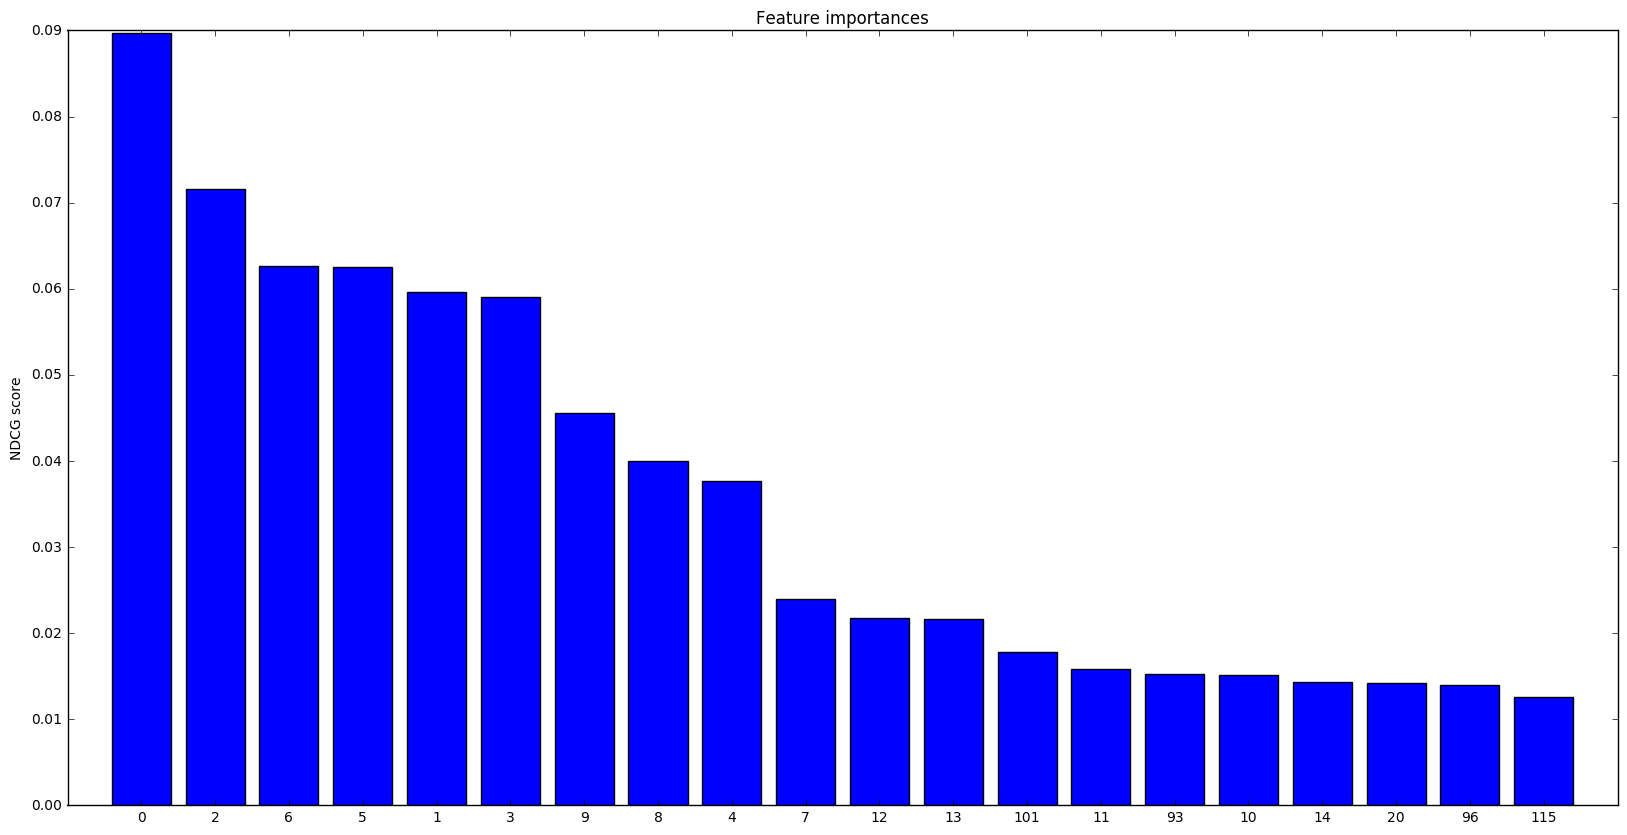

In [21]:
machine_learning_helper.plotFeaturesImportance(model,X_train)

The figure above shows the 20 most important features following the NDCG score. The age feature is by far the most important one. 

The figure below shows the most important features using the F score. 

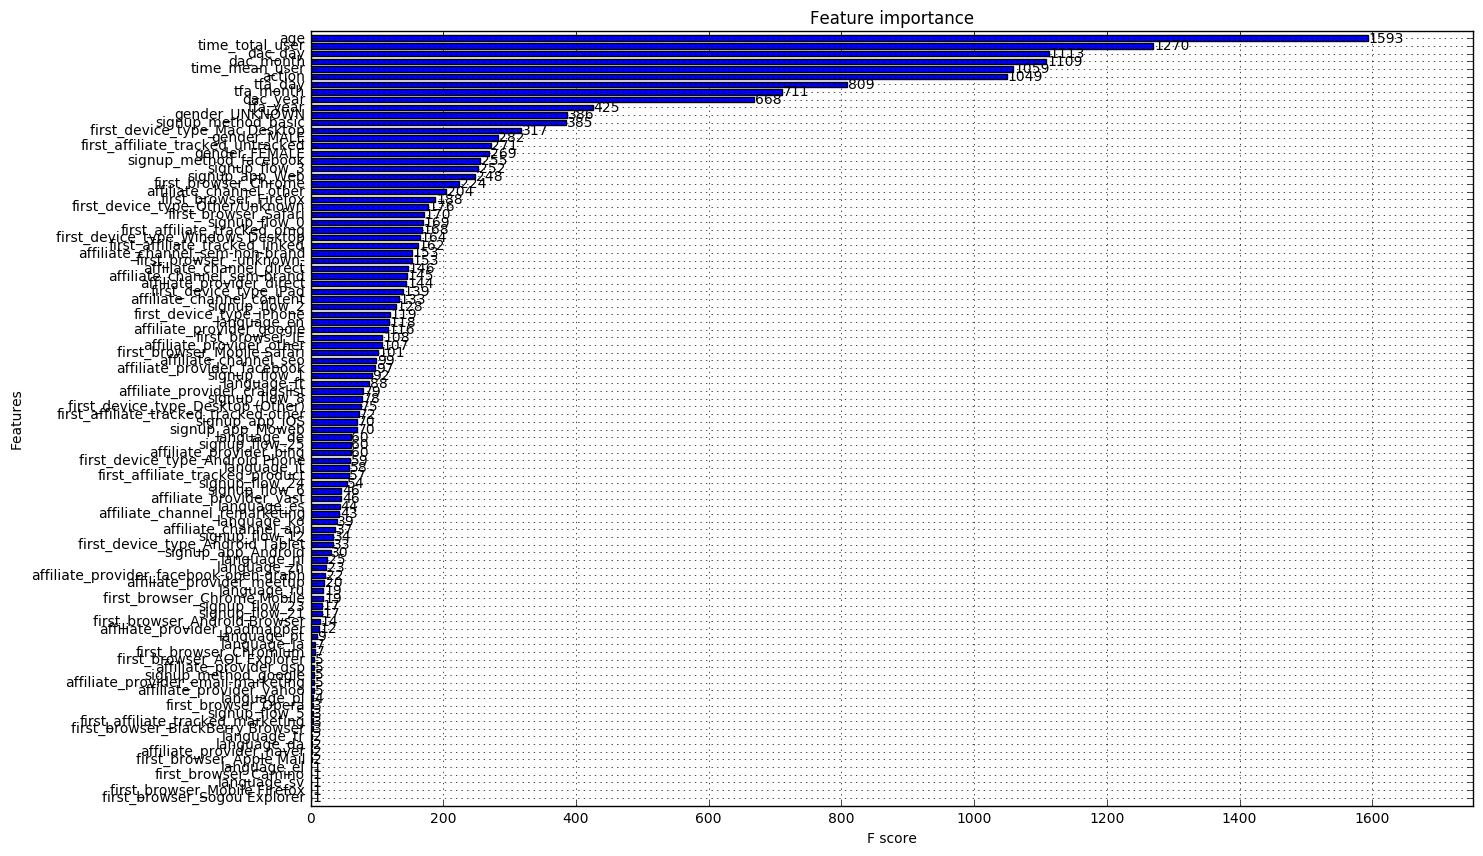

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))
xgb.plot_importance(model,height=0.7, ax=ax)

Feature ranking:
1. feature age (0.123761), indice 0
2. feature time_mean_user (0.094504), indice 2
3. feature time_total_user (0.089607), indice 1
4. feature action (0.088138), indice 3
5. feature gender_FEMALE (0.035133), indice 156
6. feature gender_MALE (0.025462), indice 5
7. feature gender_UNKNOWN (0.025217), indice 6
8. feature signup_method_basic (0.022402), indice 90
9. feature signup_method_facebook (0.021667), indice 7
10. feature signup_method_google (0.020933), indice 4
11. feature signup_method_weibo (0.019709), indice 95
12. feature signup_flow_0 (0.018974), indice 14
13. feature signup_flow_1 (0.016771), indice 58
14. feature signup_flow_2 (0.015179), indice 8
15. feature signup_flow_3 (0.015179), indice 11
16. feature signup_flow_4 (0.014935), indice 87
17. feature signup_flow_5 (0.013955), indice 84
18. feature signup_flow_6 (0.013466), indice 13
19. feature signup_flow_8 (0.012731), indice 144
20. feature signup_flow_10 (0.012731), indice 98


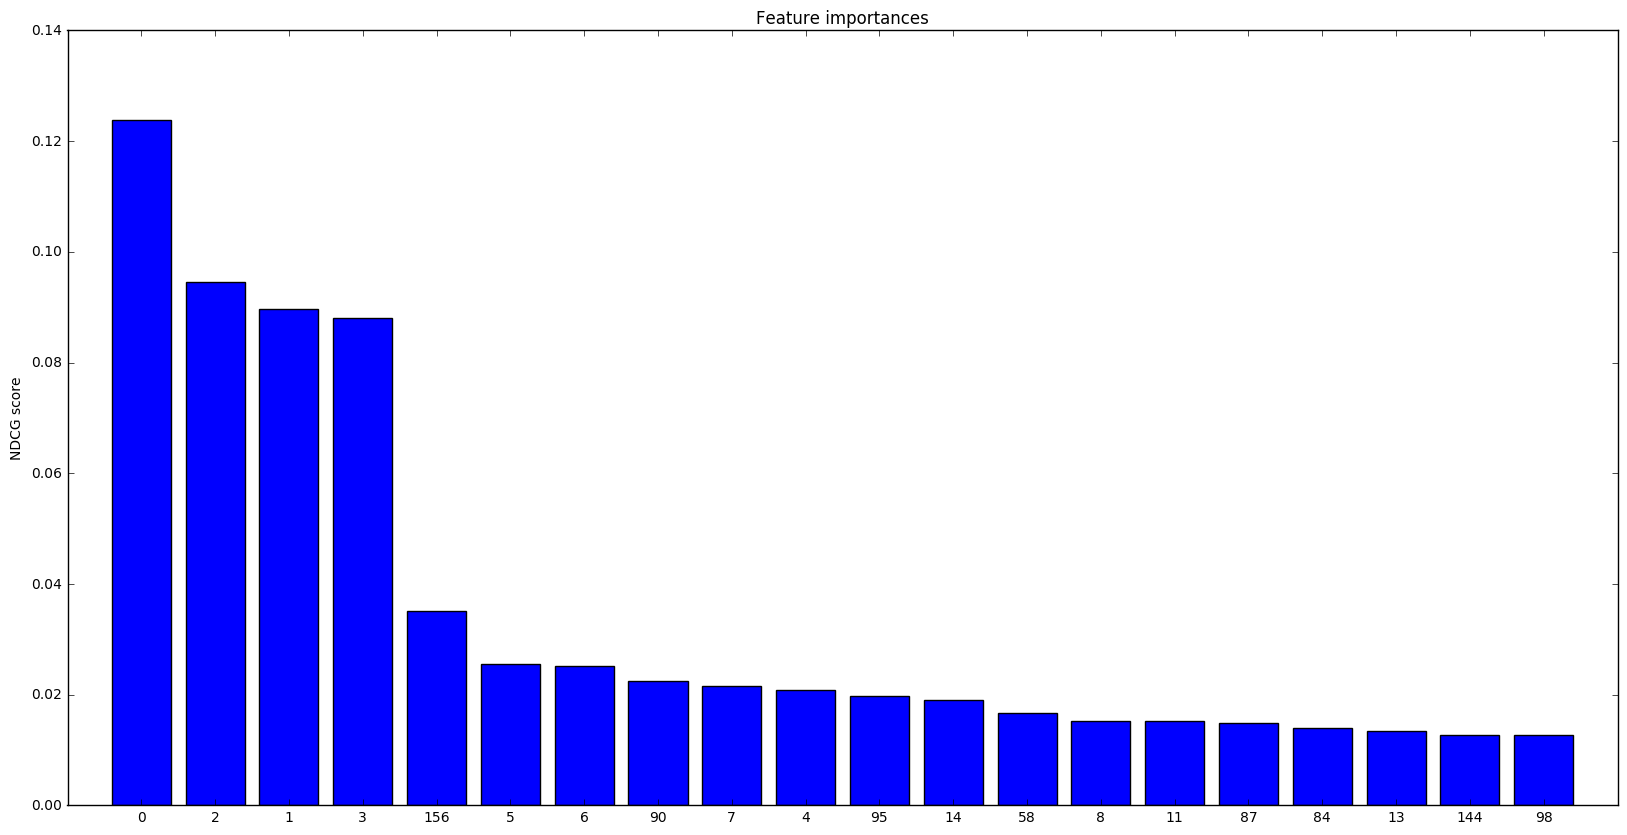

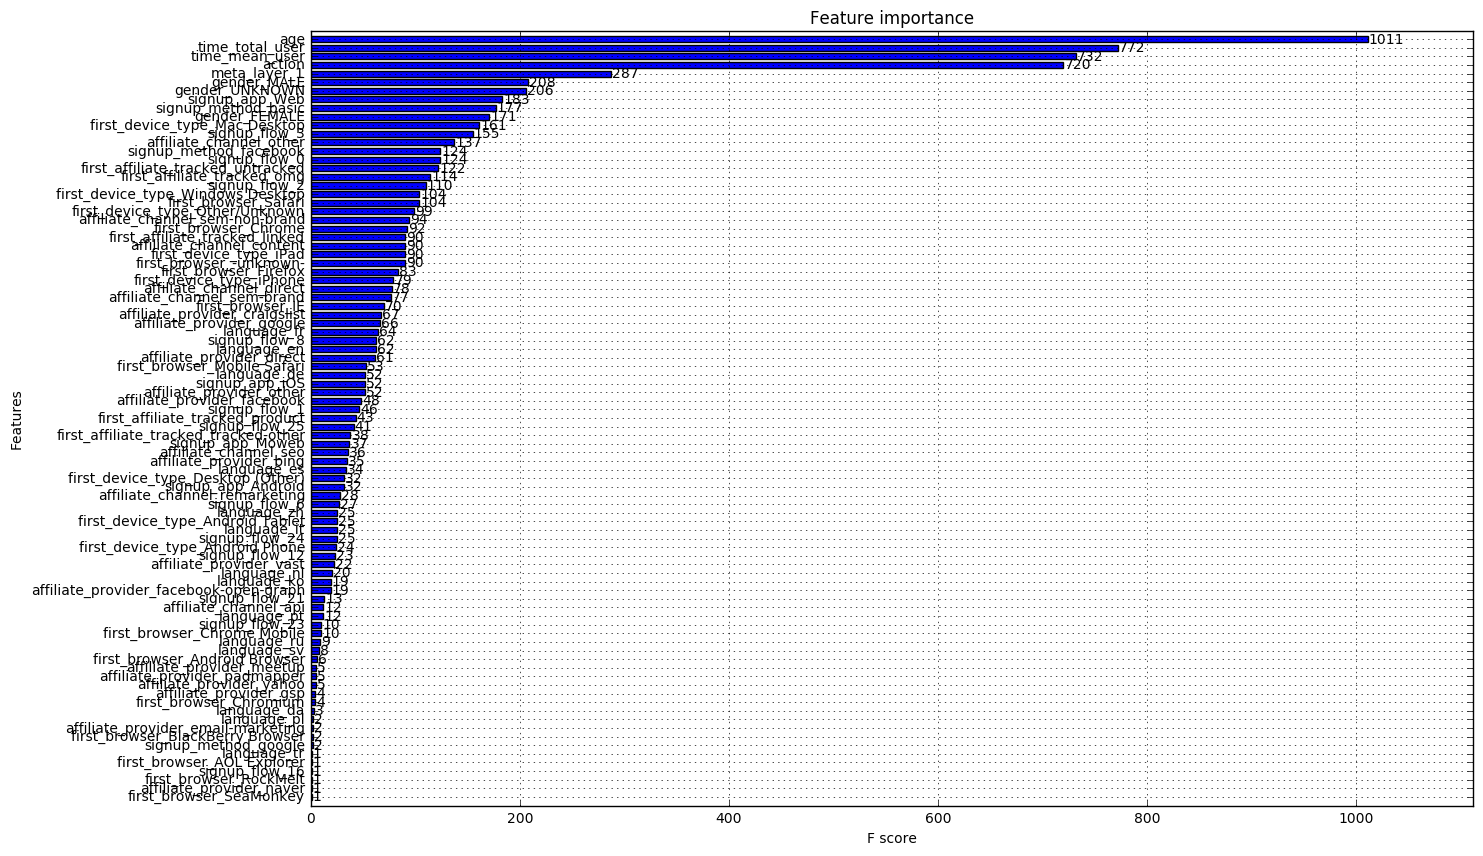

In [23]:
machine_learning_helper.plotFeaturesImportance(XGB_model,X_train_layer2)
fig, ax = plt.subplots(figsize=(15, 10))
xgb.plot_importance(XGB_model,height=0.7, ax=ax)

- The features importance plots of the 2 Layer stack model show that the importance of the features is much better distributed over 4 main features instead of 1. 
- The meta_layer_1 feature comes fourth in the importance feature ranking and justifies the 2 layers approach.


# Conclusion : 
- With our best model, which is a XGBoost, we can predict the destination choosen by Airbnb users with a **NDCG score of 0.86967**.
- The most important features to predict the destination are the age of the user and the day he created his account and the the time spent by the users, the action and the meta_layer_1 feature for the 2L stack model.
- The stacking model which is more complicated is not better than the simple XGBoost. This is explained by the fact that the first layer logistic regression is not a good classifier. Its accuracy and F1 scores are just above 60%. Hence, the XGBoost in the 2nd layer is not able to fully exploit this feature. 
- The voting model which is also more complicated is not better than the simple XGBoost.

Simpler is better ?